### Imports

In [223]:
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import seaborn as sns

In [224]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Data from Source

In [225]:
# Drive'a upload ettiğim ilgili json dosyasını okuyorum ve 'time' feature'ını 'index' olarak set ediyorum.
df = pd.read_json("/content/drive/MyDrive/weather.json")

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')
df.set_index('time', inplace=True)

df.head()

,feels_like,humidity,location,temperature,wind_direction,wind_speed
time,,,,,,
2024-08-25 02:31:19,17.62,68,Konya,17.99,20,3.6
2024-08-25 02:32:19,17.62,68,Konya,17.99,20,3.6
2024-08-25 02:33:19,17.62,68,Konya,17.99,20,3.6
2024-08-25 02:34:19,17.62,68,Konya,17.99,20,3.6
2024-08-25 02:35:19,17.62,68,Konya,17.99,20,3.6


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2024-08-25 02:31:19 to 2024-08-25 14:30:31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   feels_like      720 non-null    float64
 1   humidity        720 non-null    int64  
 2   location        720 non-null    object 
 3   temperature     720 non-null    float64
 4   wind_direction  720 non-null    int64  
 5   wind_speed      720 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 39.4+ KB


### EDA (exploratory data analysis)

In [227]:
# InfluxDB'de yalnızca 'Konya' iline ait verileri topladığımdan dolayı, bu feature'ın bizim için bir önemi kalmıyor. Bundan dolayı veri setimden çıkartıyorum.
df = df.drop('location', axis=1)

In [228]:
# Mean: İlgili feature'a ait ortalama değeri gösterir. Örneğin, 'temperature' için ortalama sıcaklık 20.36 derece.
# Std: Standart sapma, verilerin ortalama (mean) etrafında ne kadar dağıldığını gösterir. "temperature" için 1.41 derece civarında bir dağılım var.
# Std: Bu da bizlere sıcaklık değerlerinin büyük çoğunluğunun 20.36°C ± 1.41°C aralığında olduğunu gösterir.
# 25%: Verilerin %25'inin bu değerden küçük olduğunu gösterir. "temperature" için verilerin %25'i 18.99 derecenin altında.
# 50% (Median): Verilerin yarısı bu değerden küçük, yarısı büyüktür. "temperature" için ortanca sıcaklık 19.99 derece.
# 75%: Verilerin %75'inin bu değerden küçük olduğunu gösterir. "temperature" için verilerin %75'i 20.99 derecenin altında.

df.describe()

,feels_like,humidity,temperature,wind_direction,wind_speed
count,720.000000,720.000000,720.000000,720.000000,720.000000
mean,23.497694,47.940278,23.848319,133.681944,4.498389
std,3.339589,12.392538,3.383719,157.336065,1.102246
min,17.620000,32.000000,17.990000,2.000000,2.490000
25%,20.710000,36.000000,20.990000,14.000000,3.310000
50%,23.570000,43.000000,23.990000,30.000000,4.630000
75%,26.810000,60.000000,26.990000,350.000000,5.140000
max,27.420000,71.000000,28.010000,360.000000,6.170000


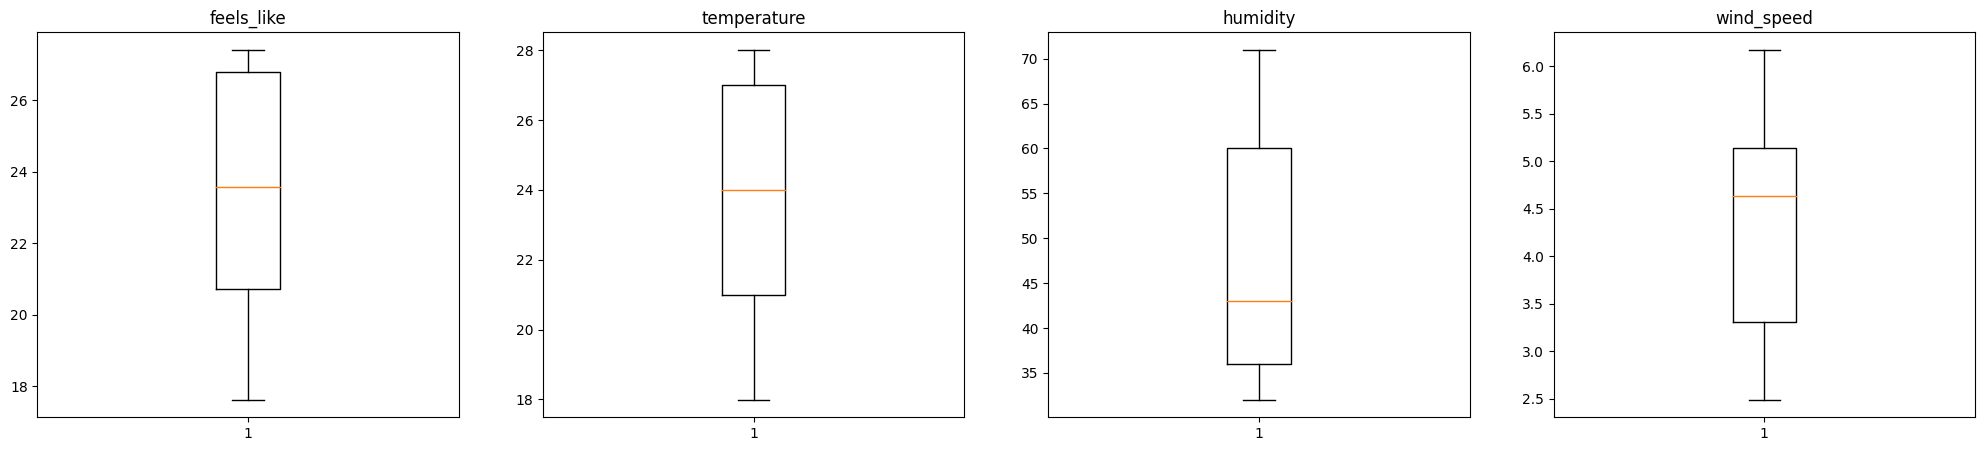

In [229]:
# Feature'lara ait dağılımları ve ortalamaları daha iyi gözlemlemek adına çeşitli grafikler.
# Buradaki kutular, Q1-Q3 aralığını, turuncu renkli çizgiler ise ilgili feature'ın medyanını ifade etmekte.

plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.boxplot(df['feels_like'])
plt.title("feels_like")

plt.subplot(142)
plt.boxplot(df['temperature'])
plt.title("temperature")

plt.subplot(143)
plt.boxplot(df['humidity'])
plt.title("humidity")

plt.subplot(144)
plt.boxplot(df['wind_speed'])
plt.title("wind_speed")


plt.show()

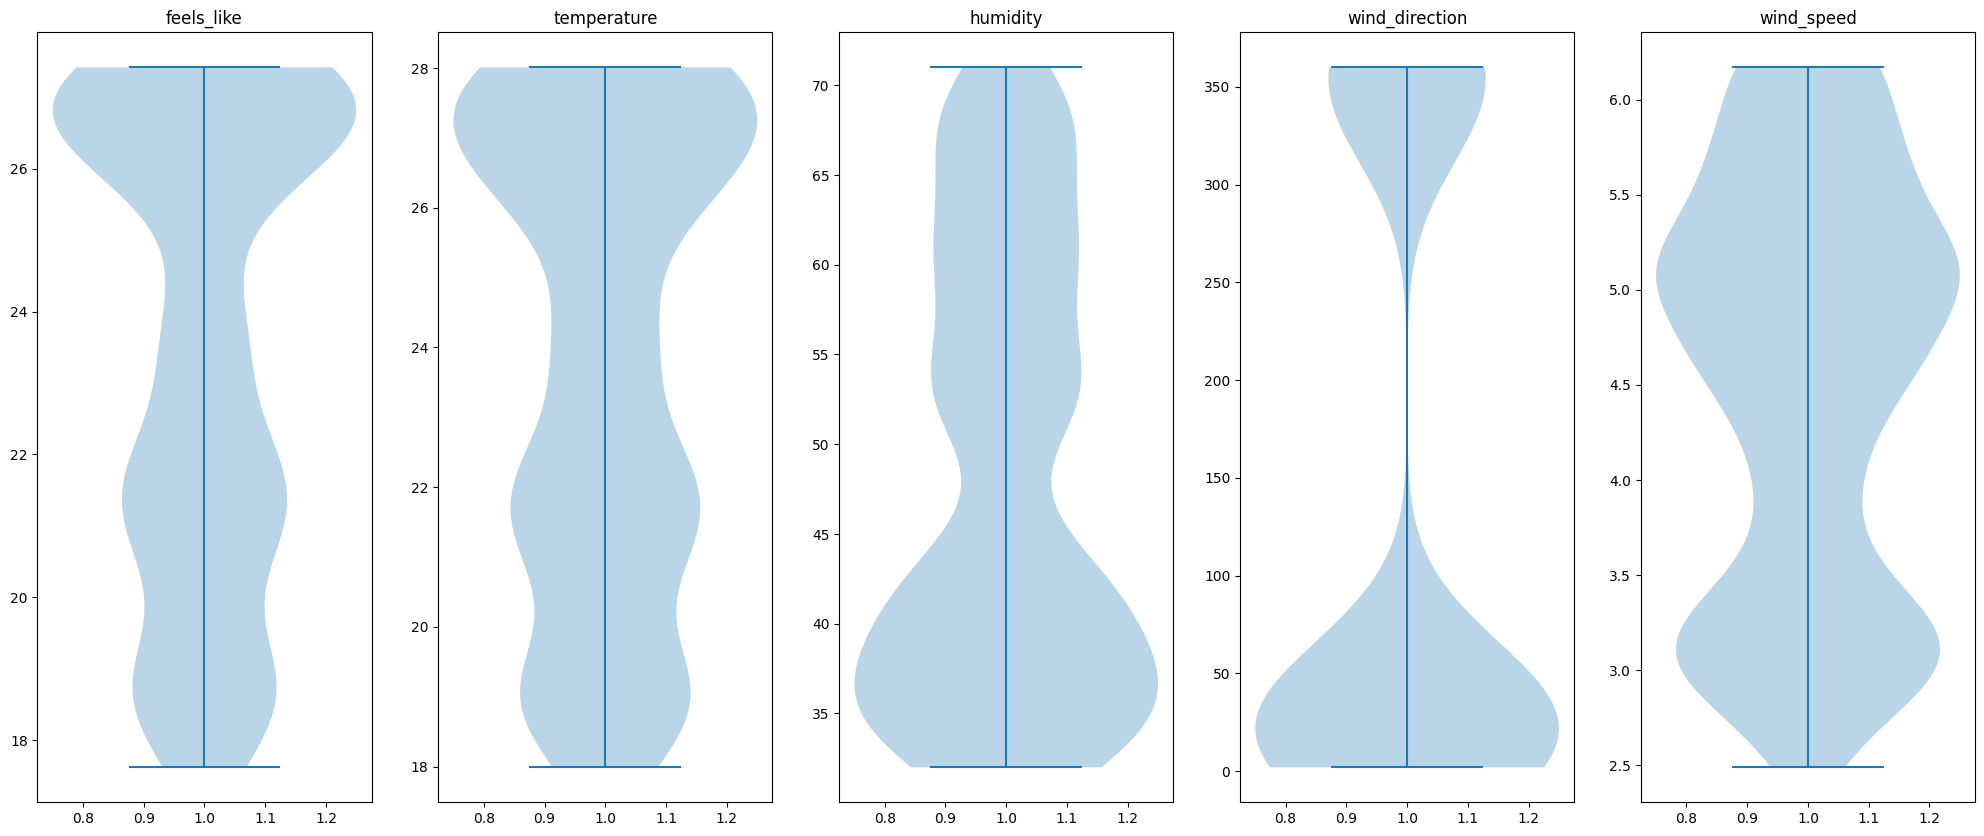

In [230]:
# Aynı şekilde ilgili feature'ların dağılımlarını gözlemlemek için bir grafik daha.
fig, (ax, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(25, 10))

ax.violinplot(df['feels_like'])
ax.set_title("feels_like")

ax2.violinplot(df['temperature'])
ax2.set_title("temperature")

ax3.violinplot(df['humidity'])
ax3.set_title("humidity")

ax4.violinplot(df['wind_direction'])
ax4.set_title("wind_direction")

ax5.violinplot(df['wind_speed'])
ax5.set_title("wind_speed")

plt.show()

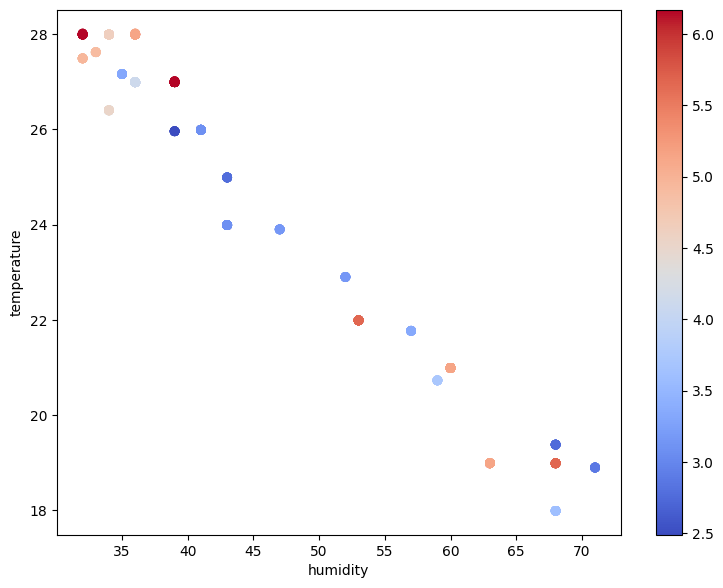

In [231]:
# marker size -> wind speed
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.scatter(df["humidity"], df["temperature"], c=df["wind_speed"], cmap="coolwarm")
plt.xlabel("humidity")
plt.ylabel("temperature")

plt.colorbar()
plt.show()

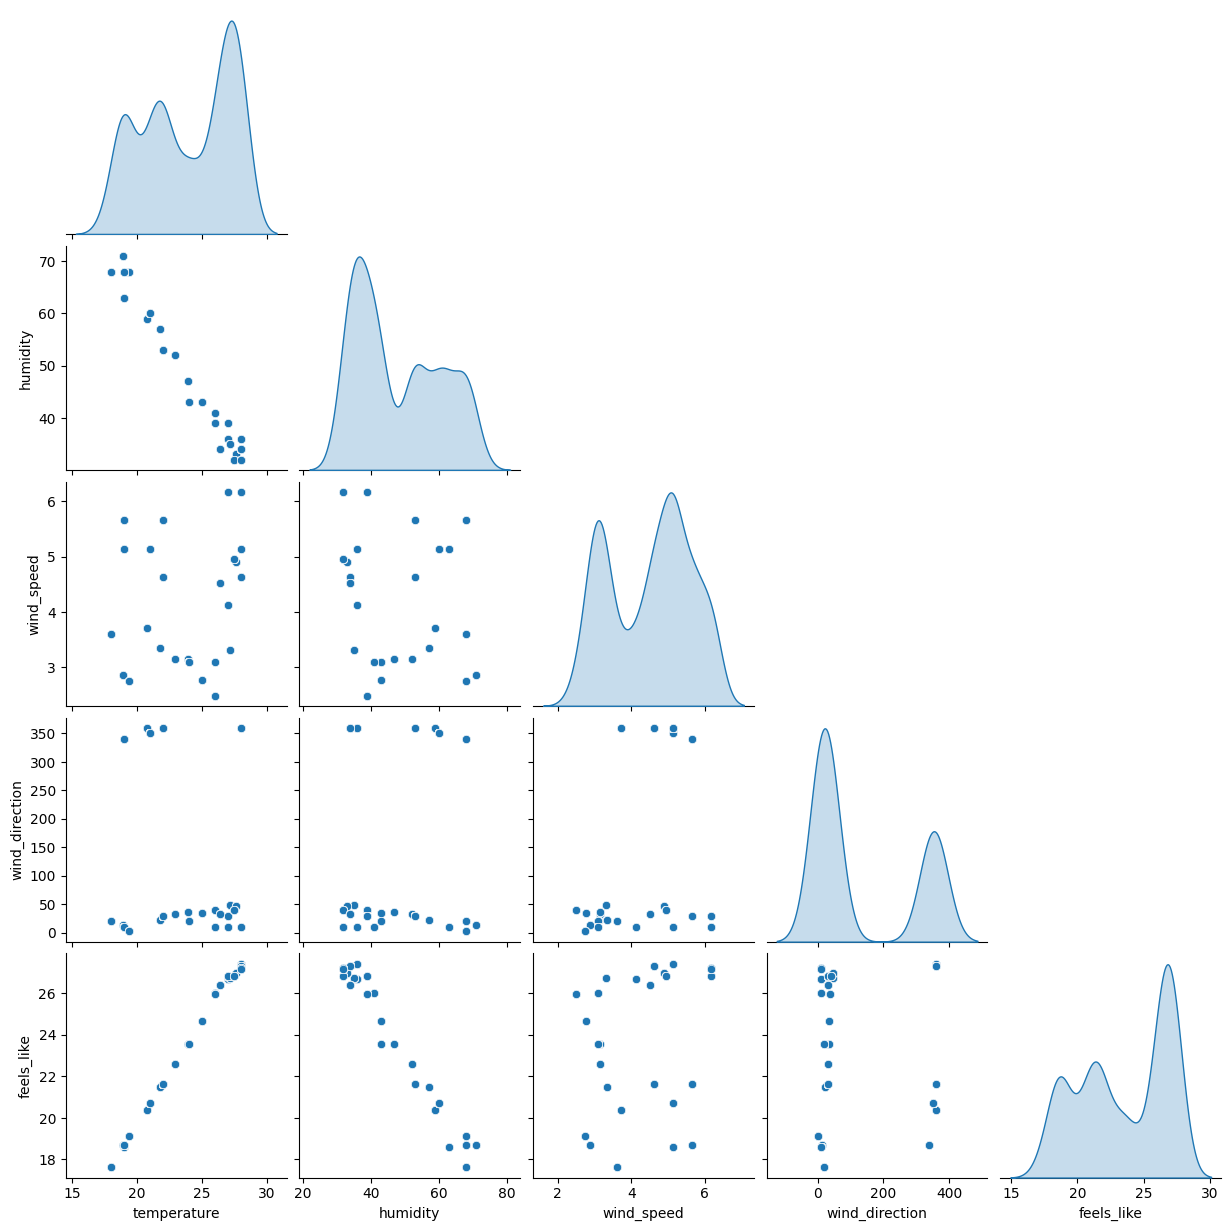

In [232]:
# Veri setindeki her bir feature çifti arasındaki ilişkiler görselleştirilmiştir.
# Bu noktada feature çiftleri arasındaki korelasyonlar ve dağılımlar incelenebilir.

sns.pairplot(df, vars=['temperature', 'humidity', 'wind_speed', 'wind_direction', 'feels_like'], diag_kind='kde', corner=True)
plt.show()

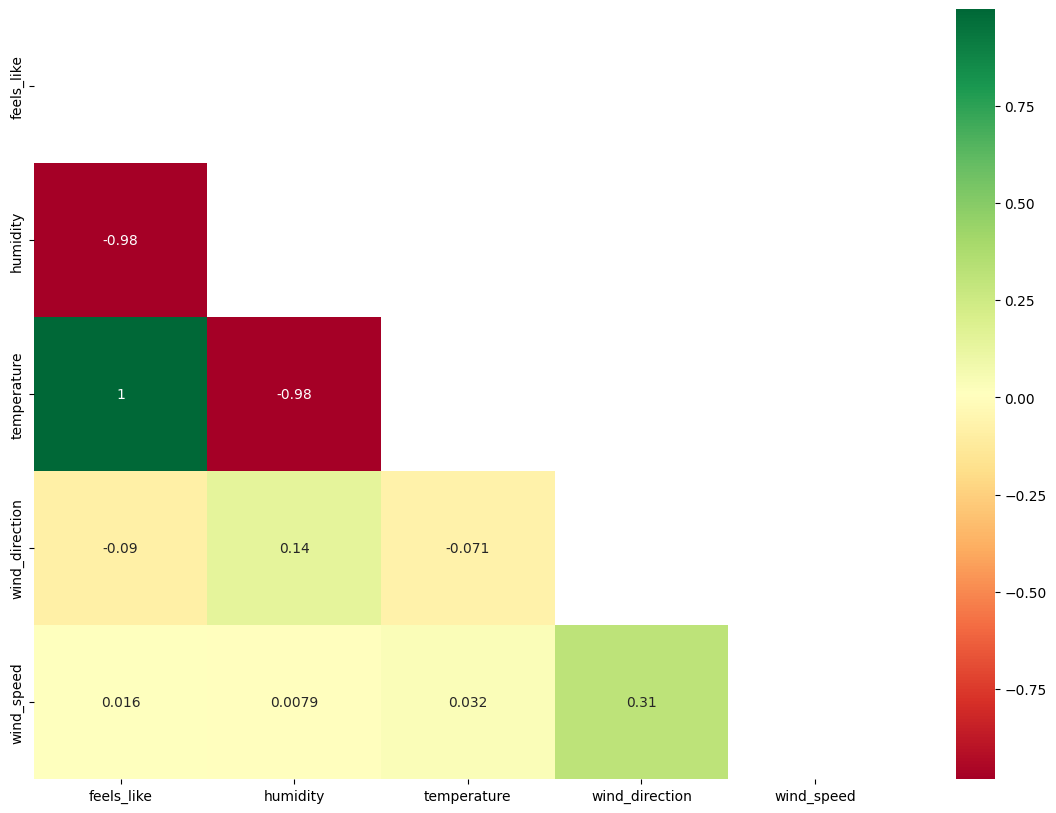

In [233]:
# Pozitif Korelasyon: Yeşil renkli bölgeler, feature'lar arasında pozitif bir ilişki olduğunu gösterir. Yani, bir değişken artarken diğeri de artar.
# Negatif Korelasyon: Kırmızı renkli bölgeler, feature'lar arasında negatif bir ilişki olduğunu gösterir. Yani, bir değişken artarken diğeri azalır.
# Zayıf Korelasyon: Renklerin daha nötr olduğu bölgeler, zayıf veya neredeyse sıfır olan korelasyonları gösterir.

plt.figure(figsize = (14,10))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(),cmap="RdYlGn",mask = mask,annot=True)
plt.show()

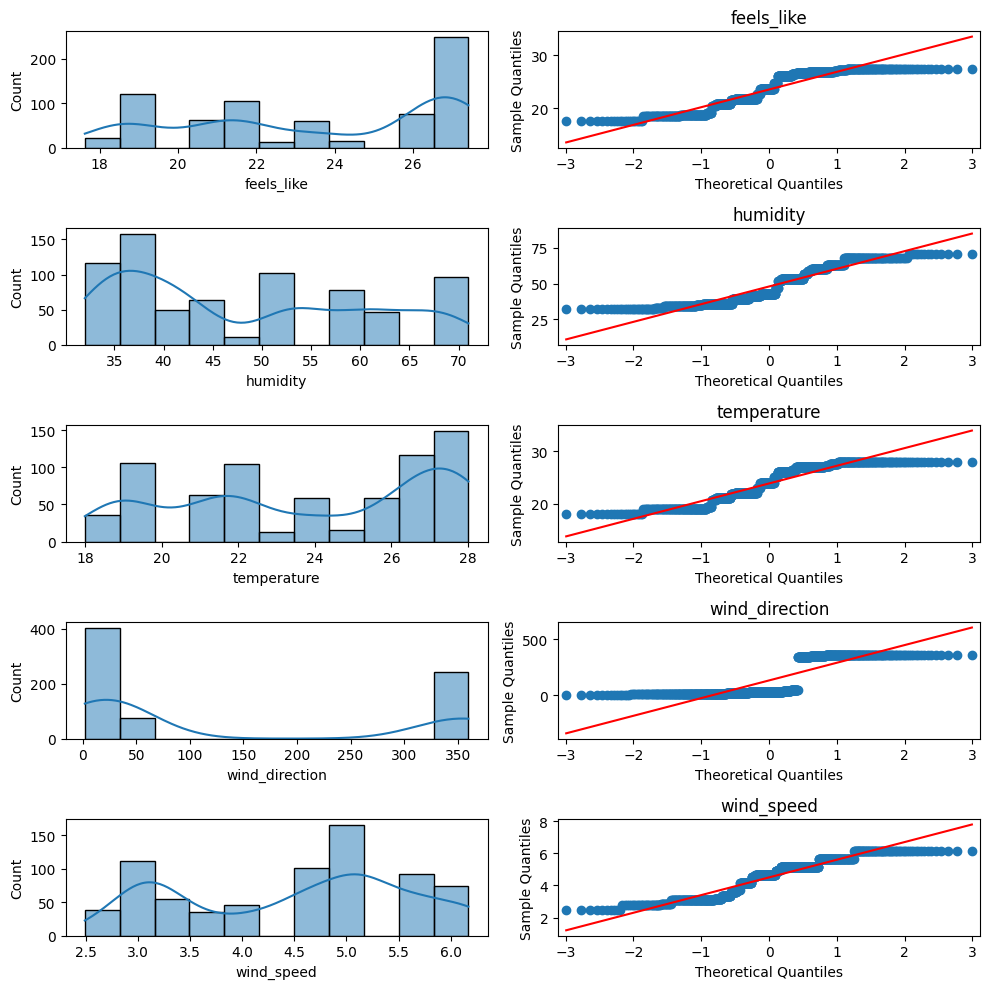

In [234]:
# Skewed Q-Q Plots - normallik testi
import statsmodels.api as sm

# Normal dağılım q ile verinin q'sunun kesiştiği noktaların çizilmesi.

# Her veri voktasına kendi quantile değeri verilir.
# Normal curve üzerine, yukarıdaki quantile sayısına göre eşit aralıklarla bölünür.
# O veri noktasının, veri seti üzerindeki quantile değeri bulunup, bu iki quantile'ın kesiştiği nokta bulunuyor.
# Bu noktaların, grafikte çizilen doğruya olan uzaklığı, veri noktasının normal dağılımdan ne kadar uzak olduğunu gösteriyor.

fig,axes = plt.subplots(len(df.columns),2,figsize=(10, len(df.columns)*2))
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax = axes[i,0],kde =True)
    sm.qqplot(df[col].dropna(),line = "s",fmt = "b",ax = axes[i,1])
    axes[i, 1].set_title(col)

plt.tight_layout()
plt.show()

In [235]:
# IQR ile outlier değerlerimizi buluyoruz.
# Outlier değerlerimizi, 1.5 * IQR ile üst ve alt sınırlarımızı belirliyoruz.
# Outlier değerlerimizi, üst ve alt sınırlarımız ile değiştiriyoruz-baskılıyoruz.

def detect_capp_outliers(df, columns):
    for col in columns:

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df[col] = np.where(df[col] > upper, upper,
                  np.where(df[col] < lower, lower, df[col]))

    return df

df = detect_capp_outliers(df,df.columns)


### LSTM (Long-Short Term Memory)

In [236]:
import os
import tensorflow as tf

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [237]:
lstm_df = df.reset_index()
lstm_df = lstm_df[['time', 'temperature', 'humidity', 'wind_speed']]

lstm_df.head()

,time,temperature,humidity,wind_speed
0,2024-08-25 02:31:19,17.99,68.0,3.6
1,2024-08-25 02:32:19,17.99,68.0,3.6
2,2024-08-25 02:33:19,17.99,68.0,3.6
3,2024-08-25 02:34:19,17.99,68.0,3.6
4,2024-08-25 02:35:19,17.99,68.0,3.6


In [238]:
lstm_df.index = pd.to_datetime(lstm_df['time'])
lstm_df.drop('time', axis=1, inplace=True)
lstm_df['Seconds'] = lstm_df.index.map(pd.Timestamp.timestamp)
lstm_df = lstm_df.ffill()
lstm_df.sort_index(inplace=True)
lstm_df

,temperature,humidity,wind_speed,Seconds
time,,,,
2024-08-25 02:31:19,17.99,68.0,3.60,1.724553e+09
2024-08-25 02:32:19,17.99,68.0,3.60,1.724553e+09
2024-08-25 02:33:19,17.99,68.0,3.60,1.724553e+09
2024-08-25 02:34:19,17.99,68.0,3.60,1.724553e+09
2024-08-25 02:35:19,17.99,68.0,3.60,1.724553e+09
...,...,...,...,...
2024-08-25 14:26:27,27.99,32.0,6.17,1.724596e+09
2024-08-25 14:27:27,28.01,32.0,6.17,1.724596e+09
2024-08-25 14:28:27,28.01,32.0,6.17,1.724596e+09


In [239]:
day = 60 * 60 * 24
year = 365.2425 * day

lstm_df['Day sin'] = np.sin(lstm_df['Seconds'] * (2 * np.pi / day))
lstm_df['Day cos'] = np.cos(lstm_df['Seconds'] * (2 * np.pi / day))
lstm_df['Year sin'] = np.sin(lstm_df['Seconds'] * (2 * np.pi / year))
lstm_df['Year cos'] = np.cos(lstm_df['Seconds'] * (2 * np.pi / year))
lstm_df = lstm_df.drop('Seconds', axis=1)
lstm_df.head()

,temperature,humidity,wind_speed,Day sin,Day cos,Year sin,Year cos
time,,,,,,,
2024-08-25 02:31:19,17.99,68.0,3.6,0.613309,0.789843,-0.804978,-0.593304
2024-08-25 02:32:19,17.99,68.0,3.6,0.616750,0.787159,-0.804985,-0.593295
2024-08-25 02:33:19,17.99,68.0,3.6,0.620178,0.784461,-0.804993,-0.593285
2024-08-25 02:34:19,17.99,68.0,3.6,0.623595,0.781747,-0.805000,-0.593275
2024-08-25 02:35:19,17.99,68.0,3.6,0.627000,0.779019,-0.805007,-0.593266


In [240]:
def df_to_X_y(df, window_size=10):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = df_as_np[i:i + window_size]
        X.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(lstm_df, window_size=10)
X.shape, y.shape


((710, 10, 7), (710,))

In [241]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))


X_train shape: (426, 10, 7)
X_test shape: (142, 10, 7)
y_train shape: (426,)
y_test shape: (142,)
X_val shape: (142, 10, 7)
y val shape: (142,)


In [242]:
def preprocess(X):
    for i in range(X.shape[2]):
        X[:, :, i] = (X[:, :, i] - np.nanmean(X[:, :, i])) / np.nanstd(X[:, :, i])
    return X

def preprocess_output(y):
    y = (y - np.nanmean(y)) / np.nanstd(y)
    return y

X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

y_train = preprocess_output(y_train)
y_val = preprocess_output(y_val)
y_test = preprocess_output(y_test)


In [243]:
model_lstm = Sequential()
model_lstm.add(tf.keras.layers.InputLayer((10, X_train.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(32))
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1))

model_lstm.summary()

cp = ModelCheckpoint('model_lstm.keras', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')

model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00002), metrics=[RootMeanSquaredError()])

history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, callbacks=[early_stopping, cp], shuffle=False)

model_lstm = load_model('model_lstm.keras')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 32)                  │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,393 (21.07 KB)

 Trainable params: 5,393 (21.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.8346 - root_mean_squared_error: 0.9134 - val_loss: 0.8434 - val_root_mean_squared_error: 0.9184
Epoch 2/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8084 - root_mean_squared_error: 0.8990 - val_loss: 0.8193 - val_root_mean_squared_error: 0.9052
Epoch 3/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7826 - root_mean_squared_error: 0.8845 - val_loss: 0.7951 - val_root_mean_squared_error: 0.8917
Epoch 4/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7571 - root_mean_squared_error: 0.8700 - val_loss: 0.7712 - val_root_mean_squared_error: 0.8782
Epoch 5/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7322 - root_mean_squared_error: 0.8555 - val_loss: 0.7477 - val_root_mean_squared_error: 0.8647
Epoch 6/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7079 - root_mean_squared_error: 0.8412 - val_loss: 0.7248 - val_root_mean_squared_error: 0.8513
Epoch 7/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.

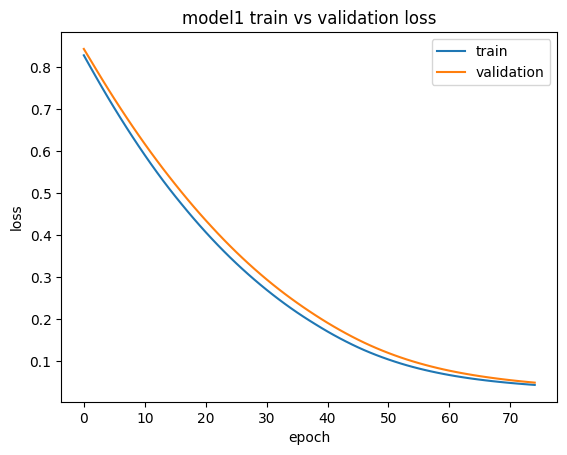

In [244]:
from matplotlib import pyplot

pyplot.plot(history_lstm.history['loss'])
pyplot.plot(history_lstm.history['val_loss'])
pyplot.title('model1 train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [245]:
# calculate MAE, MSE between expected and predicted values
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

preds = model_lstm.predict(X_train).flatten()
results = pd.DataFrame(data={'Preds': preds[:len(y_train)], 'Actual': y_train})

mae = mean_absolute_error(results['Actual'], results['Preds'])
mse = mean_squared_error(results['Actual'], results['Preds'])
rmse = sqrt(mse)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 0.169
MSE: 0.043
RMSE: 0.207


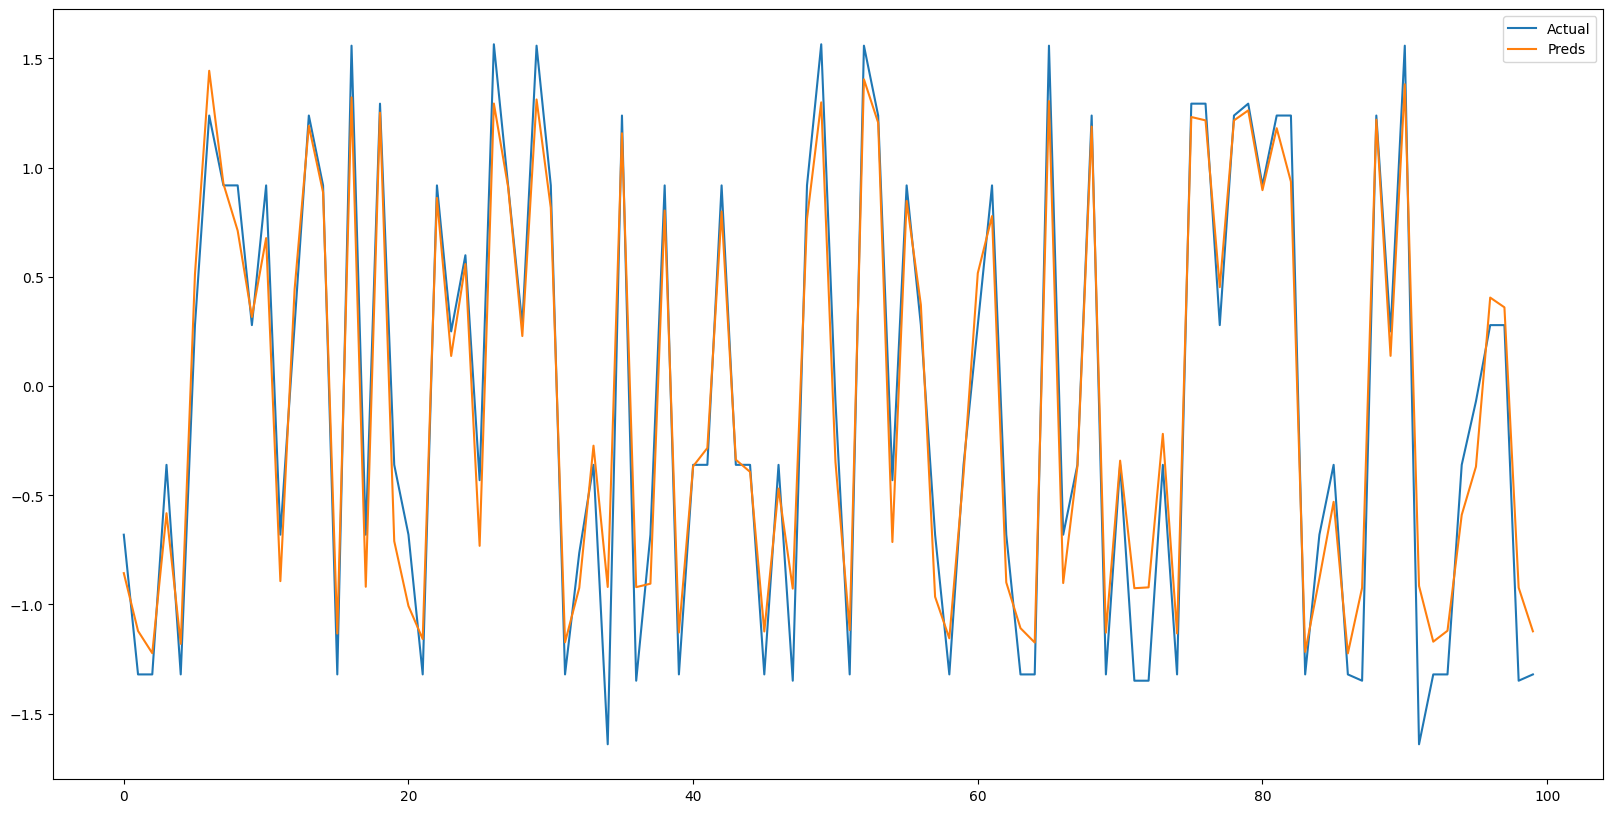

In [246]:
plt.figure(figsize=(20,10))
plt.plot(y_train[0:100])
plt.plot(preds[0:100])
plt.legend(['Actual', 'Preds'])
plt.show()

In [247]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'],
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=results.index, y=results['Preds'],
                    mode='lines',
                    name='Preds'))
fig.update_layout(
    width=1250,
    height=500,
    title="Actual vs Predicted",
    xaxis_title="Observation",
    yaxis_title="temperature",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

In [248]:
results['Preds'] = results['Preds'].apply(lambda x: round(x, 2))
results['Actual'] = results['Actual'].apply(lambda x: round(x, 2))
results['Diff'] = results['Preds'] - results['Actual']
results['Diff'] = results['Diff'].apply(lambda x: round(x, 2))
results['Diff %'] = results['Diff'] / results['Actual']
results['Diff %'] = results['Diff %'].apply(lambda x: round(x, 2))
results


,Preds,Actual,Diff,Diff %
0,-0.86,-0.68,-0.18,0.26
1,-1.12,-1.32,0.20,-0.15
2,-1.22,-1.32,0.10,-0.08
3,-0.58,-0.36,-0.22,0.61
4,-1.18,-1.32,0.14,-0.11
...,...,...,...,...
421,-1.13,-1.32,0.19,-0.14
422,-1.18,-1.32,0.14,-0.11
423,-0.41,-0.36,-0.05,0.14
424,0.94,0.91,0.03,0.03


In [249]:
last_date = lstm_df.index[-1]

# 12 saat boyunca 1 dakikalık aralıklarla yeni zaman dilimleri oluşturma
future_dates = pd.date_range(start=last_date, periods=1*60, freq='T')

In [250]:
# İkinciye dönüştürme
future_seconds = future_dates.map(pd.Timestamp.timestamp)

# Özelliklerin hesaplanması
future_data = pd.DataFrame(index=future_dates)
future_data['Day sin'] = np.sin(future_seconds * (2 * np.pi / day))
future_data['Day cos'] = np.cos(future_seconds * (2 * np.pi / day))
future_data['Year sin'] = np.sin(future_seconds * (2 * np.pi / year))
future_data['Year cos'] = np.cos(future_seconds * (2 * np.pi / year))


In [251]:
# Tahminler için yer ayırma
predictions = []

# Başlangıç durumu olarak son 10 gözlemi kullanma
current_window = lstm_df[-10:].values

for i in range(len(future_data)):
    # Tahmini yap
    pred = model_lstm.predict(current_window[np.newaxis, :, :])[0][0]
    predictions.append(pred)

    # Pencereyi kaydır (son tahmini ekle, ilk girdiyi çıkar)
    current_window = np.roll(current_window, -1, axis=0)
    current_window[-1, 0] = pred

def inverse_preprocess_output(y_scaled, original_data):
    mean = np.nanmean(original_data)
    std = np.nanstd(original_data)
    return y_scaled * std + mean


# Tahminlerin eklenmesi
future_data['Forecast'] = [inverse_preprocess_output(p, lstm_df['temperature']) for p in predictions]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [252]:
import plotly.graph_objects as go

# Geçmiş veri ve tahminleri birleştir
full_data = pd.concat([lstm_df[['temperature']].reset_index(), future_data.reset_index()], ignore_index=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=full_data['time'], y=full_data['temperature'],
                         mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_data.index, y=future_data['Forecast'],
                         mode='lines', name='Forecast'))

fig.update_layout(
    width=1250,
    height=500,
    title="Actual vs Forecast",
    xaxis_title="Time",
    yaxis_title="Temperature",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

